# Problem 1: K-means clustering and image compression (4pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2022 </div>

## Completed by:   
*   Ivan Havlytskyi
*   Oleksandr Kharytonov



### Description:
The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Links
For this task of your homework you can get **4 points** plus extra (see the last part). Do not forget to save and rename the notebook before making any changes!


To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [1]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [2]:
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import numpy as np

In [3]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch (1.5 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [4]:
import random
import numpy as np
from scipy.spatial.distance import cdist

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    # ========= YOUR CODE STARTS HERE ========= #

    random_indices = np.random.choice(
      X.shape[0], size=self.K,
      replace=False # to avoid duplicate centroids
      )

    centroids = X[random_indices].copy()

    # ========== YOUR CODE ENDS HERE ========== #
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    # ========= YOUR CODE STARTS HERE ========= #

    return cdist(X, centroids, metric=self.metric) # already was imported

    # ========== YOUR CODE ENDS HERE ========== #


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1) # FIXED .sum(-1) -> consider storing centroids each on separate axis

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)

    # ========= YOUR CODE STARTS HERE ========= #

    onehot_mask = (mask == np.arange(self.K).reshape(-1,1))
    onehot_clusters = X * onehot_mask[...,np.newaxis] # new axis with num_clusters number of coords to place each vector on separate coord based on the cluster (zeros else)

    new_centroids = onehot_clusters.sum(axis=1) / onehot_mask.sum(axis=1)[...,np.newaxis]

    # ========== YOUR CODE ENDS HERE ========== #

    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- intiialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    # return None
    # ========= YOUR CODE STARTS HERE ========= #

    centroids = self.init_centroids(X)

    for i in range(self.I):
      new_centroids = self.update_clusters(X, centroids)
      
      delta = np.linalg.norm(new_centroids - centroids)
      if delta < self.E:
        return new_centroids
      
      centroids = new_centroids

    return centroids
    # ========== YOUR CODE ENDS HERE ========== #


## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [5]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

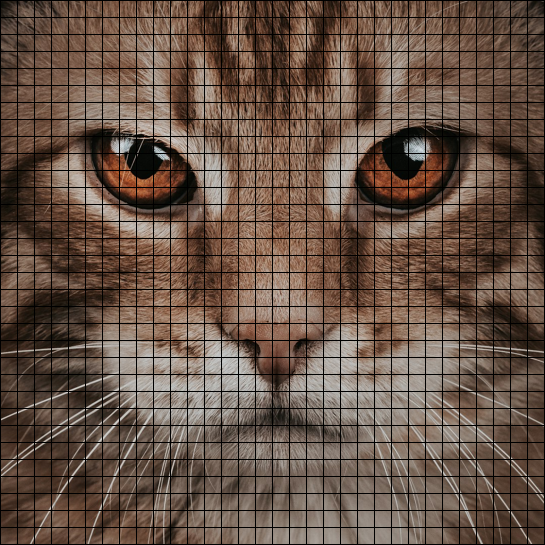

In [6]:
visualize_patches(patches, padding=1)

In [7]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

### Try out your implementation!

In [8]:
# initialize KMeans algo
kmeans = KMeans(128, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)


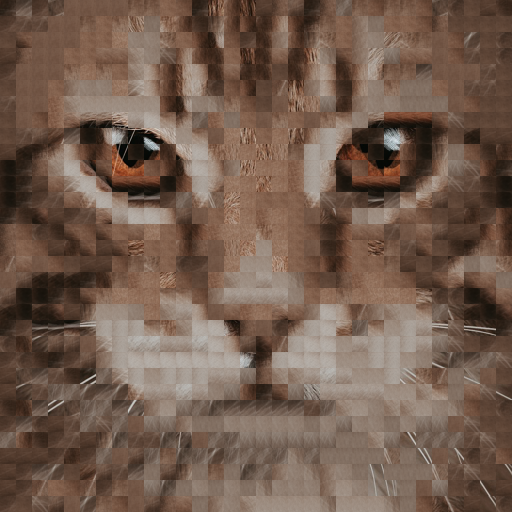

In [9]:
visualize_patches(predicted.reshape(-1,3,m,m))

### Task 2: Discussion (0.5 pt)

 Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality?


---

\### **YOUR ANSWER HERE** \###

---

## 3. Elbow method (1.4 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters $k$ and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.4 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [ ]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray) -> float:
    distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #

    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

### Task 4: Calculate & Visualize (0.5 pt)
Let's use above implemented function to calculate distortion for some $k$ values and visualize our results

In [ ]:
# You can choose your own values for the range
#(it may take some time to run the loop, so feel free to optimize your code ;=)
k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
#calculate distortion values
for k in k_range:
  pass
  # ========= YOUR CODE STARTS HERE ========= #

  # ========== YOUR CODE ENDS HERE ========== #

# Plot your results
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #

### Task 5: Summarize (0.5 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion?

What is the compression rate with this optimal value?

---

\### **YOUR ANSWER HERE** \###

---

## 4. Conclusions (0.6 pt)

---


### Task 6 (0.6 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---

\### **YOUR ANSWER HERE** \###

---

## 5. Bonus Problem (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches.

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #